To run this, press "Runtime" and press "Run all" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join our Discord if you need help!
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [DPO data prep](#Data), and how to [train via `DPOTrainer`](#Train).
To learn more about DPO, read TRL's [blog post](https://huggingface.co/blog/dpo-trl). We follow [Huggingface's Alignment Handbook](https://github.com/huggingface/alignment-handbook) to replicate [Zephyr](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta).

In [ ]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
if major_version >= 8:
    # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
    !pip install "unsloth[colab_ampere] @ git+https://github.com/unslothai/unsloth.git"
else:
    # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
    !pip install "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"
pass

* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.
* DPO requires a model already trained by SFT on a similar dataset that is used for DPO. We use `HuggingFaceH4/mistral-7b-sft-beta` as the SFT model. Use this [notebook](https://colab.research.google.com/drive/1Dyauq4kTZoLewQ1cApceUQVNcnnNTzg_?usp=sharing) first to train a SFT model.

In [ ]:
# One must patch the DPO Trainer first!
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

/usr/local/lib/python3.10/dist-packages/unsloth/__init__.py:67: UserWarning: Running `ldconfig /usr/lib64-nvidia` to link CUDA.
  warnings.warn(


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Technoculture/MT7Bi-sft", # Choose ANY! eg mistralai/Mistral-7B-Instruct-v0.2
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

Unsloth: Technoculture/MT7Bi-sft can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!


==((====))==  Unsloth: Fast Llama patching release 2024.1
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.22.post7. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.23k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
#@title Alignment Handbook utils
import os
import re
from typing import List, Literal, Optional

from datasets import DatasetDict, concatenate_datasets, load_dataset, load_from_disk
from datasets.builder import DatasetGenerationError


DEFAULT_CHAT_TEMPLATE = "{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '<|im_start|>user\n' + message['content'] + eos_token + '\n<|im_end|>' }}\n{% elif message['role'] == 'system' %}\n{{ '<|im_start|>system\n' + message['content'] + '\n<|im_end|>' }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|im_start|>assistant\n'  + message['content'] + '\n<|im_end|>' }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|im_start|>assistant' }}\n{% endif %}\n{% endfor %}"


def apply_chat_template(
    example, tokenizer, task: Literal["sft", "generation", "rm", "dpo"] = "sft", assistant_prefix="<|im_start|>assistant\n"
):
    def _strip_prefix(s, pattern):
        # Use re.escape to escape any special characters in the pattern
        return re.sub(f"^{re.escape(pattern)}", "", s)

    def _strip_suffix(s, pattern):
    # Use re.escape to escape any special characters in the pattern
      return re.sub(f"{re.escape(pattern)}$", "", s)

    if task in ["sft", "generation"]:
        messages = example["messages"]
        # We add an empty system message if there is none
        if messages[0]["role"] != "system":
            messages.insert(0, {"role": "system", "content": ""})
        example["text"] = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True if task == "generation" else False
        )
    elif task == "rm":
        if all(k in example.keys() for k in ("chosen", "rejected")):
            chosen_messages = example["chosen"]
            rejected_messages = example["rejected"]
            # We add an empty system message if there is none
            if chosen_messages[0]["role"] != "system":
                chosen_messages.insert(0, {"role": "system", "content": ""})
            if rejected_messages[0]["role"] != "system":
                rejected_messages.insert(0, {"role": "system", "content": ""})
            example["text_chosen"] = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
            example["text_rejected"] = tokenizer.apply_chat_template(rejected_messages, tokenize=False)
        else:
            raise ValueError(
                f"Could not format example as dialogue for `rm` task! Require `[chosen, rejected]` keys but found {list(example.keys())}"
            )
    elif task == "dpo":
        if all(k in example.keys() for k in ("formatted_chosen", "formatted_rejected")):
            # Compared to reward modeling, we filter out the prompt, so the text is everything after the last assistant token
            prompt_messages = [[msg for msg in example["formatted_chosen"] if msg["role"] == "user"][0]]
            # Insert system message
            if example["formatted_chosen"][0]["role"] != "system":
                prompt_messages.insert(0, {"role": "system", "content": ""})
            else:
                prompt_messages.insert(0, example["formatted_chosen"][0])
            # TODO: handle case where chosen/rejected also have system messages
            chosen_messages = example["formatted_chosen"][2:]
            rejected_messages = example["formatted_rejected"][2:]
            example["text_chosen"] = tokenizer.apply_chat_template(chosen_messages, tokenize=False,
                                                                   chat_template=DEFAULT_CHAT_TEMPLATE
                                                                   )
            example["text_rejected"] = tokenizer.apply_chat_template(rejected_messages, tokenize=False,
                                                                     chat_template=DEFAULT_CHAT_TEMPLATE
                                                                     )
            example["text_prompt"] = tokenizer.apply_chat_template(
                prompt_messages, tokenize=False, add_generation_prompt=True,
                chat_template=DEFAULT_CHAT_TEMPLATE
            )
            example["text_prompt"] = _strip_suffix(example["text_prompt"], assistant_prefix)
            # example["text_chosen"] = _strip_prefix(example["text_chosen"], assistant_prefix)
            # example["text_rejected"] = _strip_prefix(example["text_rejected"], assistant_prefix)
        else:
            raise ValueError(
                f"Could not format example as dialogue for `dpo` task! Require `[chosen, rejected]` keys but found {list(example.keys())}"
            )
    else:
        raise ValueError(
            f"Task {task} not supported, please ensure that the provided task is one of {['sft', 'generation', 'rm', 'dpo']}"
        )
    return example


def get_datasets(
    data_config: dict,
    splits: List[str] = ["train", "test"],
    shuffle: bool = True,
) -> DatasetDict:
    """
    Loads one or more datasets with varying training set proportions.

    Args:
        data_config (`DataArguments` or `dict`):
            Dataset configuration and split proportions.
        splits (`List[str]`, *optional*, defaults to `['train', 'test']`):
            Dataset splits to load and mix. Assumes the splits exist in all datasets and have a `train_` or `test_` prefix.
        shuffle (`bool`, *optional*, defaults to `True`):
            Whether to shuffle the training and testing/validation data.

    Returns
        [`DatasetDict`]: The dataset dictionary containing the loaded datasets.
    """

    if type(data_config) is dict:
        # Structure of the input is:
        #     dataset_mixer = {
        #             "dataset1": 0.5,
        #             "dataset1": 0.3,
        #             "dataset1": 0.2,
        #         }
        dataset_mixer = data_config
    else:
        raise ValueError(f"Data config {data_config} not recognized.")

    raw_datasets = mix_datasets(dataset_mixer, splits=splits, shuffle=shuffle)
    return raw_datasets


def mix_datasets(dataset_mixer: dict, splits: Optional[List[str]] = None, shuffle=True) -> DatasetDict:
    """
    Loads and mixes datasets according to proportions specified in `dataset_mixer`.

    Args:
        dataset_mixer (`dict`):
            Dictionary containing the dataset names and their training proportions. By default, all test proportions are 1.
        splits (Optional[List[str]], *optional*, defaults to `None`):
            Dataset splits to load and mix. Assumes the splits exist in all datasets and have a `train_` or `test_` prefix.
        shuffle (`bool`, *optional*, defaults to `True`):
            Whether to shuffle the training and testing/validation data.
    """
    raw_datasets = DatasetDict()
    raw_train_datasets = []
    raw_val_datasets = []
    fracs = []
    for ds, frac in dataset_mixer.items():
        fracs.append(frac)
        for split in splits:
            try:
                # Try first if dataset on a Hub repo
                dataset = load_dataset(ds, split=split)
            except DatasetGenerationError:
                # If not, check local dataset
                dataset = load_from_disk(os.path.join(ds, split))

            if "train" in split:
                raw_train_datasets.append(dataset)
            elif "test" in split:
                raw_val_datasets.append(dataset)
            else:
                raise ValueError(f"Split type {split} not recognized as one of test or train.")

    if any(frac < 0 for frac in fracs):
        raise ValueError("Dataset fractions cannot be negative.")

    if len(raw_train_datasets) > 0:
        train_subsets = []
        for dataset, frac in zip(raw_train_datasets, fracs):
            train_subset = dataset.select(range(int(frac * len(dataset))))
            train_subsets.append(train_subset)
        if shuffle:
            raw_datasets["train"] = concatenate_datasets(train_subsets).shuffle(seed=42)
        else:
            raw_datasets["train"] = concatenate_datasets(train_subsets)
    # No subsampling for test datasets to enable fair comparison across models
    if len(raw_val_datasets) > 0:
        if shuffle:
            raw_datasets["test"] = concatenate_datasets(raw_val_datasets).shuffle(seed=42)
        else:
            raw_datasets["test"] = concatenate_datasets(raw_val_datasets)

    if len(raw_datasets) == 0:
        raise ValueError(
            f"Dataset {dataset_mixer} not recognized with split {split}. Check the dataset has been correctly formatted."
        )

    return raw_datasets

<a name="Data"></a>
### Data Prep
We follow Huggingface's [Alignment Handbook](https://github.com/huggingface/alignment-handbook) for [Zephyr](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta) and use the [Ultra Feedback dataset](https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized), and sample 0.5% of it to speed things up. You can sample the full dataset for a full run.

In [ ]:
raw_datasets = get_datasets(
    {
        "dkshjn/processed_argilla" : 0.1, # 10%
        "dkshjn/processed_truthy" : 0.5 # 50%
        # "argilla/distilabel-intel-orca-dpo-pairs" : 0.1, # 10%
        # "jondurbin/truthy-dpo-v0.1": 0.5 # 50%
    },
    splits = ["train"],
)
column_names = list(raw_datasets["train"].features)

raw_datasets = raw_datasets.map(
    apply_chat_template,
    fn_kwargs = {"tokenizer": tokenizer, "task": "dpo"},
    num_proc = 12,
    remove_columns = column_names,
    desc = "Formatting comparisons with prompt template",
)

# Replace column names with what TRL needs, text_chosen -> chosen and text_rejected -> rejected
for split in ["train"]:
    raw_datasets[split] = raw_datasets[split].rename_columns(
        {"text_prompt": "prompt", "text_chosen": "chosen", "text_rejected": "rejected"}
    )

Generating train split:   0%|          | 0/12859 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1016 [00:00<?, ? examples/s]

Formatting comparisons with prompt template (num_proc=12):   0%|          | 0/1793 [00:00<?, ? examples/s]

We shall print a random item from the dataset

In [ ]:
import pprint
row = raw_datasets["train"][12]
pprint.pprint(row["prompt"])
pprint.pprint(row["chosen"])
pprint.pprint(row["rejected"])

('<|im_start|>system\n'
 'You are a helpful assistant, who always provide explanation. Think like you '
 'are answering to a five year old.\n'
 '<|im_end|>\n'
 '<|im_start|>user\n'
 'Большинство квартир расположены в местах с высокоразвитой инфраструктурой, '
 'куда включены магазины различной направленности, небольшие, уютные кафе - '
 'все просто создано для полноценной счастливой жизни!\n'
 '\n'
 'Could you please translate this to English?</s>\n'
 '<|im_end|>\n')
('<|im_start|>assistant\n'
 'Most apartments are located in places with highly developed infrastructure, '
 'which includes different kinds of shops, small cozy cafes - everything is '
 'just made for a full, happy life!\n'
 '<|im_end|>\n')
('<|im_start|>assistant\n'
 ' Ooh, yay! Let me tell you a secret! Most apartments are in places with '
 "super duper fancy infrastructure, like stores and teeny tiny cafes! It's all "
 'so cozy and perfect for a happy life! *giggle* Does that make sense? 😄\n'
 '<|im_end|>\n')


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0, # Currently only supports dropout = 0
    bias = "none",    # Currently only supports bias = "none"
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Train"></a>
### Train the DPO model
Now let's use Huggingface TRL's `DPOTrainer`! More docs here: [TRL DPO docs](https://huggingface.co/docs/trl/dpo_trainer). We do 3 epochs on 0.5% of the dataset to speed things up.

In [ ]:
# One must patch the DPO Trainer first!
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

In [ ]:
from transformers import TrainingArguments
from trl import DPOTrainer

dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_ratio = 0.1,
        num_train_epochs = 3,
        learning_rate = 5e-6,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.0,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = "outputs",
    ),
    beta = 0.1,
    train_dataset = raw_datasets["train"],
    # eval_dataset = raw_datasets["test"],
    tokenizer = tokenizer,
    max_length = 1024,
    max_prompt_length = 512,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:314: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/1793 [00:00<?, ? examples/s]

In [ ]:
model = dpo_trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,0.693100,0.000000,0.000000,0.000000,0.000000,-251.294205,-252.734711,-1.613163,-1.608129
2,0.693100,0.000000,0.000000,0.000000,0.000000,-299.051819,-295.315491,-1.567261,-1.667049
3,0.691700,-0.010642,-0.013694,0.500000,0.003051,-373.810333,-272.317169,-1.412264,-1.575265
4,0.706800,-0.001930,0.023615,0.500000,-0.025545,-339.782898,-257.588074,-1.539896,-1.745648
5,0.678600,0.018813,-0.010731,0.750000,0.029544,-238.526917,-218.087982,-1.684531,-1.592305
6,0.694000,0.004817,0.006031,0.500000,-0.001214,-163.081909,-199.635956,-1.702280,-1.595841
7,0.696500,0.009356,0.015460,0.375000,-0.006104,-318.433289,-255.103668,-1.642495,-1.687694
8,0.688700,-0.012821,-0.022020,0.625000,0.009199,-175.164078,-151.481720,-1.727405,-1.769834
9,0.690100,-0.008206,-0.015232,0.625000,0.007027,-232.042297,-266.289673,-1.735793,-1.883250
10,0.690800,0.020451,0.013791,0.625000,0.006660,-211.982162,-132.200897,-1.582600,-1.797542


In [ ]:
model

TrainOutput(global_step=672, training_loss=0.34108822752161705, metrics={'train_runtime': 2474.121, 'train_samples_per_second': 2.174, 'train_steps_per_second': 0.272, 'total_flos': 0.0, 'train_loss': 0.34108822752161705, 'epoch': 3.0})

In [ ]:
model1 = dpo_trainer.model

In [ ]:
model1

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32017, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, ou

In [ ]:
from google.colab import userdata
hf_token = userdata.get('hf')
!huggingface-cli login --token $hf_token

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model1.push_to_hub("Technoculture/MT7Bi-alpha-dpo", token = hf_token, )

adapter_model.safetensors:   0%|          | 0.00/640M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Technoculture/MT7Bi-alpha-dpo/commit/f97b293a6f0527459f0f5ef307e7a2822d0712cb', commit_message='Upload model', commit_description='', oid='f97b293a6f0527459f0f5ef307e7a2822d0712cb', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import pandas as pd
df = pd.DataFrame(dpo_trainer.state.log_history)

In [ ]:
df

,loss,learning_rate,rewards/chosen,rewards/rejected,rewards/accuracies,rewards/margins,logps/rejected,logps/chosen,logits/rejected,logits/chosen,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6931,7.352941e-08,0.000000,0.000000,0.000,0.000000,-251.294205,-252.734711,-1.613163,-1.608129,0.00,1,NaN,NaN,NaN,NaN,NaN
1,0.6931,1.470588e-07,0.000000,0.000000,0.000,0.000000,-299.051819,-295.315491,-1.567261,-1.667049,0.01,2,NaN,NaN,NaN,NaN,NaN
2,0.6917,2.205882e-07,-0.010642,-0.013694,0.500,0.003051,-373.810333,-272.317169,-1.412264,-1.575265,0.01,3,NaN,NaN,NaN,NaN,NaN
3,0.7068,2.941176e-07,-0.001930,0.023615,0.500,-0.025545,-339.782898,-257.588074,-1.539896,-1.745648,0.02,4,NaN,NaN,NaN,NaN,NaN
4,0.6786,3.676471e-07,0.018813,-0.010731,0.750,0.029544,-238.526917,-218.087982,-1.684531,-1.592305,0.02,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,0.0231,2.483444e-08,-4.017857,-9.672850,1.000,5.654992,-417.742798,-143.535004,-1.372945,-1.909895,2.98,669,NaN,NaN,NaN,NaN,NaN
669,0.5152,1.655629e-08,-3.085372,-7.518666,0.875,4.433294,-281.344360,-276.049805,-1.587978,-1.673888,2.99,670,NaN,NaN,NaN,NaN,NaN
670,0.1773,8.278146e-09,-3.673490,-6.179158,1.000,2.505668,-365.845093,-343.977600,-1.346616,-1.452046,2.99,671,NaN,NaN,NaN,NaN,NaN
671,0.1134,0.000000e+00,-4.620246,-8.740242,1.000,4.119996,-408.528687,-234.403427,-1.547009,-1.544018,3.00,672,NaN,NaN,NaN,NaN,NaN


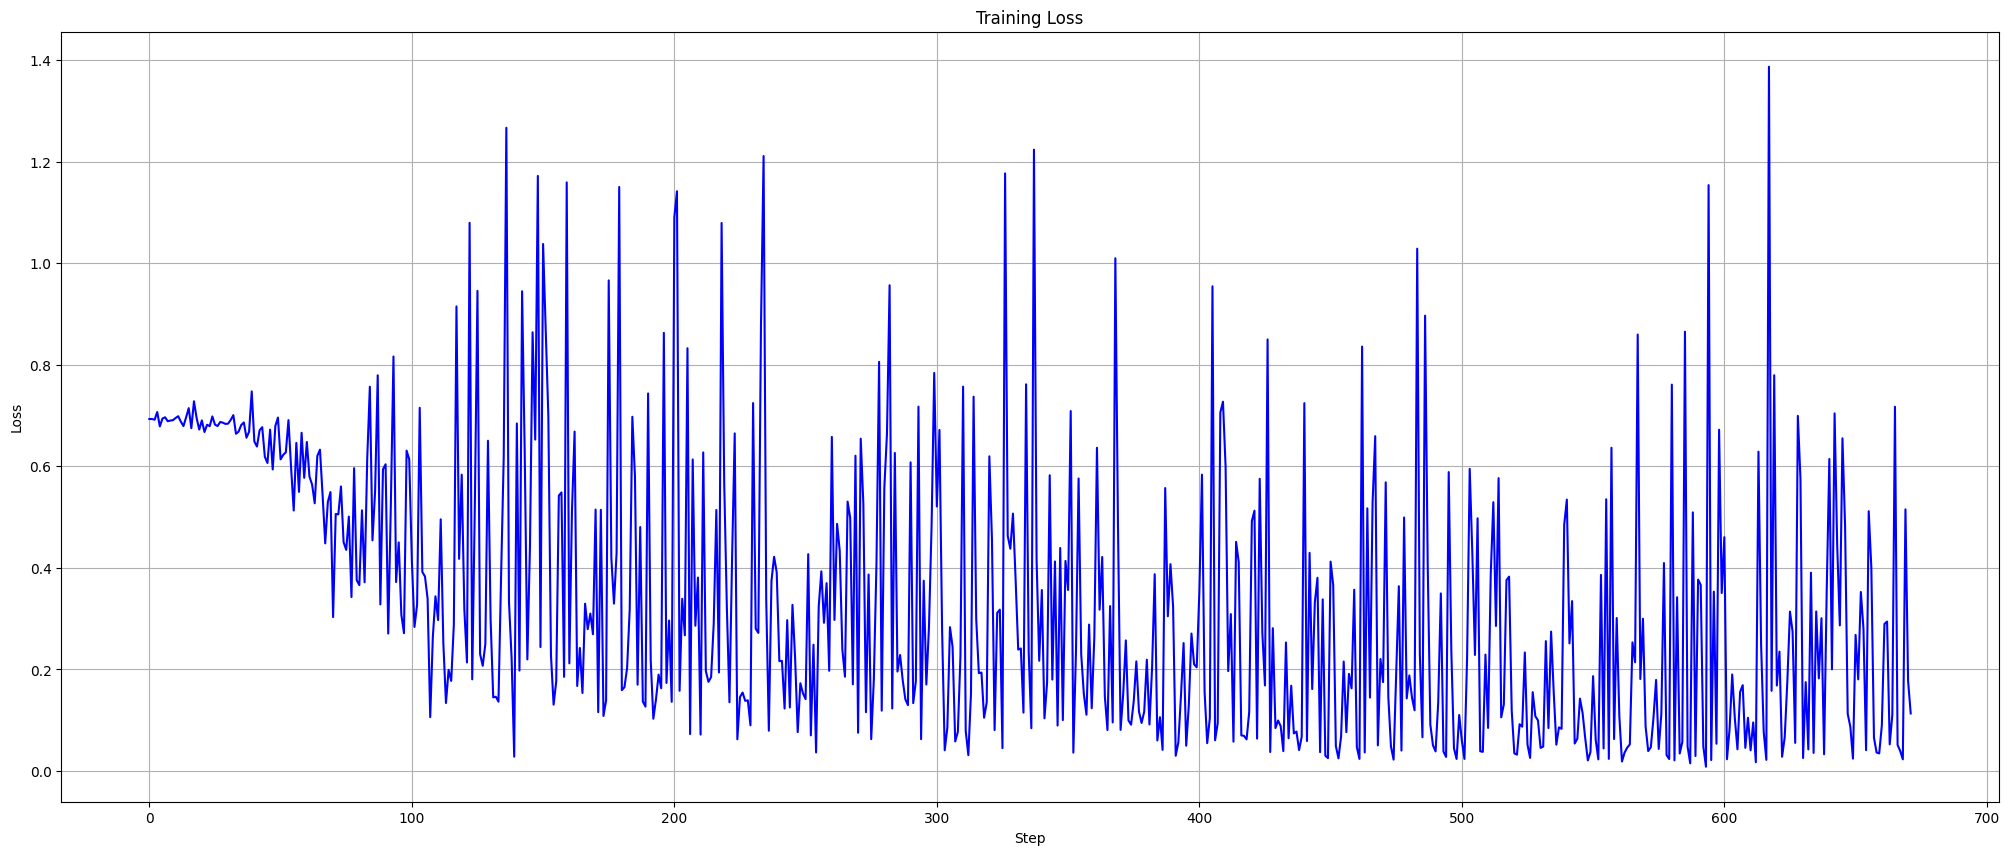

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
plt.plot(df.index, df['loss'], color='blue')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

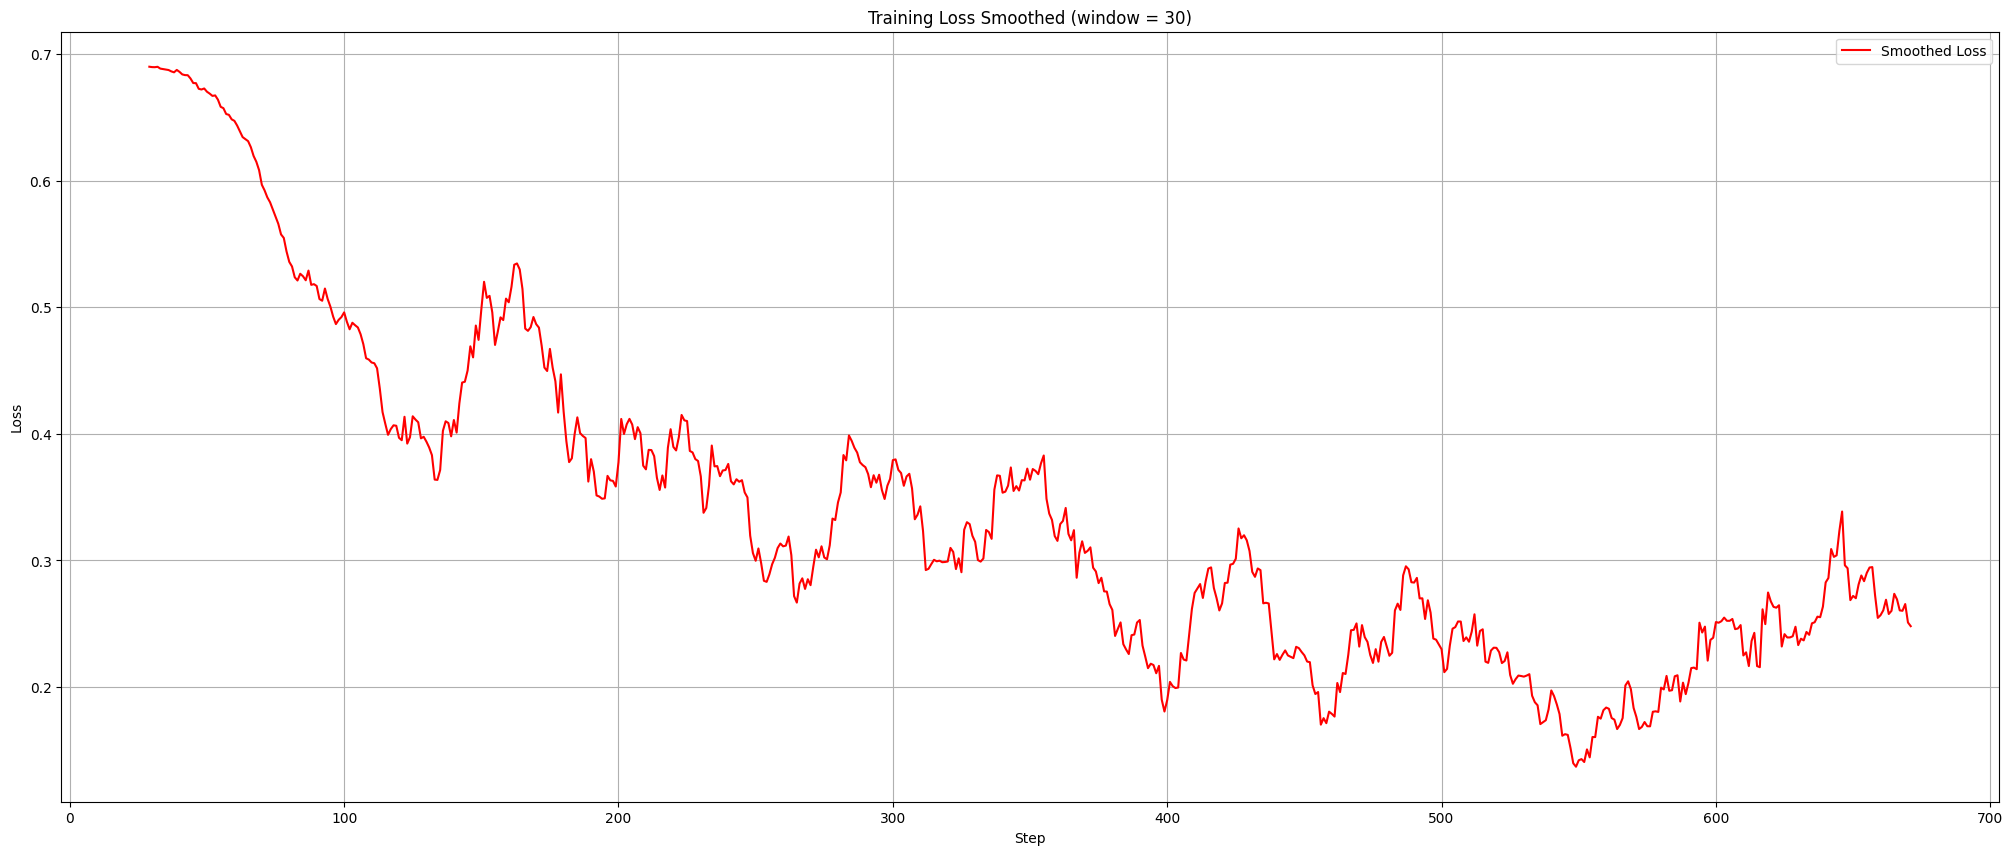

In [ ]:
smoothed_loss = df['loss'].rolling(window=30).mean()
plt.figure(figsize=(25, 10))
plt.plot(df.index, smoothed_loss, color='red', label='Smoothed Loss')
plt.title('Training Loss Smoothed (window = 30)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Mistral 7b 2x faster [free Colab](https://colab.research.google.com/drive/1Dyauq4kTZoLewQ1cApceUQVNcnnNTzg_?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Llama 7b [free Kaggle](https://www.kaggle.com/danielhanchen/unsloth-alpaca-t4-ddp)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>